<a href="https://colab.research.google.com/github/swardiantara/fp-kk-2021/blob/main/FP_KK_NER_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/alikmondal/named-entity-recognition-using-rnn

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [131]:
dataset_path = '/content/drive/MyDrive/Colab Notebooks/ner-kk/ner_datasetreference.csv'
dataset = pd.read_csv(dataset_path, encoding= 'unicode_escape')
dataset.shape

(1048575, 5)

In [132]:
dataset.head()

,Sentence #,Word,POS,Tag,Class
0,Sentence: 1,Thousands,NNS,O,0
1,NaN,of,IN,O,0
2,NaN,demonstrators,NNS,O,0
3,NaN,have,VBP,O,0
4,NaN,marched,VBN,O,0


In [133]:
dataset.drop(['POS', 'Class'], inplace=True, axis=1)

In [134]:
dataset["Tag"].value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [135]:
dataset.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


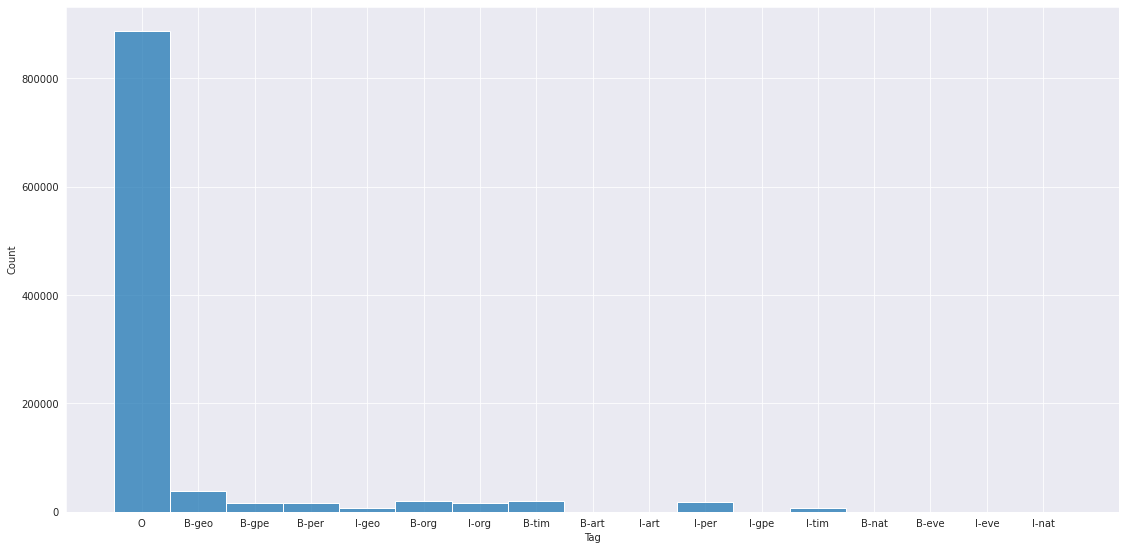

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (16,8))
sns.set_style('darkgrid')
sns.histplot(dataset['Tag'])
plt.tight_layout(pad=2)
plt.show()

In [137]:
def computeRatioAwal(dataset):
  negative = dataset.apply(lambda x : True if x['Tag'] == "O" else False, axis = 1)
  num_negative = len(negative[negative == True].index)
  num_positive = len(negative[negative == False].index)
  return num_negative / num_positive 
# Count number of True in the series

In [138]:
print(computeRatioAwal(dataset))

5.526386874716027


In [139]:
dataset_fillna = dataset.fillna(method='ffill', axis=0)
dataset_group = dataset_fillna.groupby(['Sentence #'], as_index=False)['Word', 'Tag'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [140]:
dataset_group

,Sentence #,Word,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo..."
...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [141]:
geoList = ["Eastern", "Western", "Northern", "Southern"]
orgList = ["Agency", "Federation", "Community"]
perList = ["Woods", "Pearson", "Lee", "Mills", "Mason", "Andrews", "Frederick", "Christopher"]

In [142]:
import random
def generateRandomEntity(entityType):
  if(entityType == 'GEO'):
    return random.choice(geoList)
  elif(entityType == 'ORG'):
    return random.choice(orgList)
  else:
    return random.choice(perList)

In [143]:
def nerOversample(dataset):
  last = False
  for sentence in range(0, dataset.shape[0]):
    # if (row == dataset.shape[0] - 1): last = True
    # if((dataset.loc[row, 'Tag'] == 'B-geo' and last) or (dataset.loc[row, 'Tag'] == 'B-geo' and dataset.loc[row+1, 'Tag'] == 'O')):
    #   dataset.loc[row, 'Tag'] = 'I-geo'
    #   dataset.insert(row, [dataset.loc[row, 'Sentence #'], generateRandomEntity('GEO'), 'B-geo'])

    # elif((dataset.loc[row, 'Tag'] == 'B-org' and last) or (dataset.loc[row, 'Tag'] == 'B-org' and dataset.loc[row+1, 'Tag'] == 'O')):
    #   dataset.insert(row+1, [dataset.loc[row, 'Sentence #'], generateRandomEntity('ORG'), 'I-org'])
    # elif((dataset.loc[row, 'Tag'] == 'B-per' and last) or (dataset.loc[row, 'Tag'] == 'B-per' and dataset.loc[row+1, 'Tag'] == 'O')):
    #   dataset.insert(row+1, [dataset.loc[row, 'Sentence #'], generateRandomEntity('PER'), 'I-per'])

    # sentence = 10002
    for tag in range(0, len(dataset.loc[sentence, 'Tag'])):
      if (tag == len(dataset.loc[sentence, 'Tag']) - 1): last = True
      if((dataset.loc[sentence, 'Tag'][tag] == 'B-geo' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-geo' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        dataset.loc[sentence, 'Tag'][tag] = 'I-geo'
        # dataset.loc[sentence, 'Tag_idx'][tag] = tag2idx.get('I-geo')
        dataset.loc[sentence, 'Word'].insert(tag, generateRandomEntity('GEO'))
        dataset.loc[sentence, 'Tag'].insert(tag, 'B-geo')
        # dataset.loc[sentence, 'Tag_idx'].insert(tag, tag2idx.get('B-geo'))
      elif((dataset.loc[sentence, 'Tag'][tag] == 'B-org' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-org' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        dataset.loc[sentence, 'Word'].insert(tag+1, generateRandomEntity('ORG'))
        dataset.loc[sentence, 'Tag'].insert(tag+1, 'I-org')
        # dataset.loc[sentence, 'Tag_idx'].insert(tag+1, tag2idx.get('I-org'))
      elif((dataset.loc[sentence, 'Tag'][tag] == 'B-per' and last == True) or (dataset.loc[sentence, 'Tag'][tag] == 'B-per' and dataset.loc[sentence, 'Tag'][tag+1] == 'O')):
        dataset.loc[sentence, 'Word'].insert(tag+1, generateRandomEntity('PER'))
        dataset.loc[sentence, 'Tag'].insert(tag+1, 'I-per')
        # dataset.loc[sentence, 'Tag_idx'].insert(tag+1, tag2idx.get('I-per'))
      # print(dataset.loc[sentence, 'Word'][tag], dataset.loc[sentence, 'Tag'][tag], dataset.loc[sentence, 'Tag_idx'][tag])
    #update ratio 
    # dataset.loc[sentence, 'Ratio'] = computeSentenceRatio(dataset.loc[sentence, 'Tag'])
  return dataset
      # print(dataset.loc[0, 'Tag'][tag])
      # print(dataset.loc[0, 'Tag_idx'][tag])

In [144]:
dataset_untuk_sample = dataset_group.copy()

In [145]:
dataset_sampled = nerOversample(dataset_untuk_sample)

In [146]:
dataset_sampled

,Sentence #,Word,Tag
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, I-geo, O, O, O, O, O..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, I-geo, O, ..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]"
4,Sentence: 10000,"[Eastern, U.N., relief, coordinator, Jan, Wood...","[B-geo, I-geo, O, O, B-per, I-per, I-per, O, B..."
...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Christopher...","[O, O, O, B-per, I-per, I-per, O, O, O, O, O, ..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B..."
47956,Sentence: 9997,"[Following, Western, Iran, 's, disputed, June,...","[O, B-geo, I-geo, O, O, B-tim, I-tim, O, O, O,..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [148]:
word_list = []
tag_list = []
sentence_list = []
for sentence in range(0, dataset_sampled.shape[0]):
  sentence_array = [dataset_sampled.loc[sentence, 'Sentence #']] * len(dataset_sampled.loc[sentence, 'Word'])
  sentence_list = sentence_list + sentence_array
  word_list = word_list + dataset_sampled.loc[sentence, 'Word']
  tag_list = tag_list + dataset_sampled.loc[sentence, 'Tag']
  # word_list.append(dataset_sampled.loc[sentence, 'Word'])
  # tag_list = tag_list.append(dataset_sampled.loc[sentence, 'Tag'])

In [149]:
print(len(sentence_list))
print(len(word_list))
print(len(tag_list))

1119772
1119772
1119772


In [150]:
# # df_after_sampling.loc[0, "Word"] = dataset_sampled.
# word = concat()
df_after_sampling = pd.DataFrame({'Sentence #': sentence_list, 'Word': word_list, 'Tag': tag_list})

In [151]:
df_after_sampling

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,Sentence: 1,of,O
2,Sentence: 1,demonstrators,O
3,Sentence: 1,have,O
4,Sentence: 1,marched,O
...,...,...,...
1119767,Sentence: 9999,weight,O
1119768,Sentence: 9999,in,O
1119769,Sentence: 9999,gold,O
1119770,Sentence: 9999,.,O


In [152]:
print(computeRatioAwal(df_after_sampling))

3.8294344960839113


In [171]:
df_after_sampling["Tag"].value_counts()

O        887908
I-geo     42247
B-geo     37644
I-org     36388
I-per     34011
B-tim     20333
B-org     20143
B-per     16990
B-gpe     15870
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

In [153]:
from itertools import chain
def get_dict_map(dataset, token_or_tag):
    tok2idx = {}
    idx2tok = {}
    
    if token_or_tag == 'token':
        vocab = list(set(dataset['Word'].to_list()))
    else:
        vocab = list(set(dataset['Tag'].to_list()))
    
    idx2tok = {idx:tok for  idx, tok in enumerate(vocab)}
    tok2idx = {tok:idx for  idx, tok in enumerate(vocab)}
    return tok2idx, idx2tok
token2idx, idx2token = get_dict_map(df_after_sampling, 'token')
tag2idx, idx2tag = get_dict_map(df_after_sampling, 'tag')

In [154]:
print(tag2idx)

{'I-gpe': 0, 'B-org': 1, 'B-art': 2, 'I-art': 3, 'I-org': 4, 'B-gpe': 5, 'B-per': 6, 'I-geo': 7, 'I-per': 8, 'B-geo': 9, 'I-tim': 10, 'O': 11, 'B-nat': 12, 'I-nat': 13, 'B-tim': 14, 'B-eve': 15, 'I-eve': 16}


In [11]:
print(tag2idx.get('B-geo'))

10


In [157]:
df_after_sampling['Word_idx'] = df_after_sampling['Word'].map(token2idx)
df_after_sampling['Tag_idx'] = df_after_sampling['Tag'].map(tag2idx)
df_after_sampling_fillna = df_after_sampling.fillna(method='ffill', axis=0)
# Groupby and collect columns
df_after_sampling_group = df_after_sampling_fillna.groupby(['Sentence #'], as_index=False)['Word', 'Tag', 'Word_idx', 'Tag_idx'].agg(lambda x: list(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [158]:
df_after_sampling_group

,Sentence #,Word,Tag,Word_idx,Tag_idx
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, I-geo, O, O, O, O, O...","[16508, 17088, 15567, 14065, 17944, 31862, 321...","[11, 11, 11, 11, 11, 11, 9, 7, 11, 11, 11, 11,..."
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[24030, 33814, 24773, 17546, 26595, 31640, 267...","[5, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11..."
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, I-geo, O, ...","[24167, 3723, 32397, 15242, 22124, 18508, 1234...","[11, 11, 14, 11, 11, 11, 11, 11, 9, 7, 11, 11,..."
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[1383, 24471, 21163, 24287, 26087, 17869, 3138...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11]"
4,Sentence: 10000,"[Eastern, U.N., relief, coordinator, Jan, Wood...","[B-geo, I-geo, O, O, B-per, I-per, I-per, O, B...","[14122, 10459, 3346, 6497, 33092, 25671, 12070...","[9, 7, 11, 11, 6, 8, 8, 11, 14, 11, 9, 7, 11, ..."
...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Christopher...","[O, O, O, B-per, I-per, I-per, O, O, O, O, O, ...","[17308, 1592, 4838, 19176, 28074, 15907, 30875...","[11, 11, 11, 6, 8, 8, 11, 11, 11, 11, 11, 11, ..."
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[28775, 21190, 29169, 24030, 12882, 27779, 268...","[11, 14, 11, 5, 11, 11, 11, 11, 11, 11, 11, 11..."
47956,Sentence: 9997,"[Following, Western, Iran, 's, disputed, June,...","[O, B-geo, I-geo, O, O, B-tim, I-tim, O, O, O,...","[17098, 14006, 800, 33156, 8549, 13026, 17256,...","[11, 9, 7, 11, 11, 14, 10, 11, 11, 11, 11, 11,..."
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[26476, 18352, 29169, 24054, 14065, 35030, 333...","[11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 1..."


In [15]:
def countEntity(tags):
  positive_tag = 0
  negative_tag = 0
  for tag in tags:
    # print(tag)
    if (tag == "O"):
      negative_tag += 1
    else:
      positive_tag += 1
  return positive_tag, negative_tag

In [16]:
def computeInitialRatio(dataset):
  for sentence in range(0, dataset.shape[0]):
    # print (sentence)
    # print(dataset.loc[sentence]["Word"])
    positive_sample, negative_sample = countEntity(dataset.loc[sentence]["Tag"])
    # print(positive_sample, negative_sample)
    
    
    if(positive_sample == 0):
      # dataset.loc[sentence]["Ratio"] = dataset.loc[sentence]["Ratio"].replace([dataset.loc[sentence]["Ratio"]], negative_sample)
      dataset.loc[sentence, "Ratio"] = negative_sample
      # print(dataset.loc[sentence]["Ratio"])
      # print('no positive sample')
    else:
      ratio = negative_sample / positive_sample
      # print(ratio)
      dataset.loc[sentence, "Ratio"] = ratio
      # dataset.loc[sentence, "Ratio"] = dataset.loc[sentence]["Ratio"].replace([dataset.loc[sentence]["Ratio"]], ratio)
      # print(dataset.loc[sentence, "Ratio"])
  return dataset

In [17]:
def computeSentenceRatio(tags):
  positive_sample, negative_sample = countEntity(tags)
  if(positive_sample == 0):
    return negative_sample
  else:
    return negative_sample / positive_sample

In [18]:
dataset_baru = computeInitialRatio(dataset_group)

In [19]:
dataset_baru

,Sentence #,Word,Tag,Word_idx,Tag_idx,Ratio
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo...","[16509, 17089, 15568, 14066, 17945, 31861, 302...","[12, 12, 12, 12, 12, 12, 10, 12, 12, 12, 12, 1...",7.000000
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[24032, 33813, 24774, 17547, 26596, 31639, 267...","[6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12...",7.333333
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, O, O, O, O...","[24169, 3724, 32396, 15243, 22126, 18509, 1234...","[12, 12, 15, 12, 12, 12, 12, 12, 10, 12, 12, 1...",5.400000
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[1383, 24472, 21165, 24289, 26088, 17870, 3138...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]",11.000000
4,Sentence: 10000,"[U.N., relief, coordinator, Jan, Egeland, said...","[B-geo, O, O, B-per, I-per, O, B-tim, O, B-geo...","[10460, 3347, 6498, 33091, 12071, 13775, 19369...","[10, 12, 12, 7, 9, 12, 15, 12, 10, 12, 6, 12, ...",3.375000
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mousavi, ha...","[O, O, O, B-per, I-per, O, O, O, O, O, O, O, O...","[17309, 1592, 4839, 19177, 15908, 30874, 13775...","[12, 12, 12, 7, 9, 12, 12, 12, 12, 12, 12, 12,...",5.400000
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[28775, 21192, 29168, 24032, 12883, 27779, 268...","[12, 15, 12, 6, 12, 12, 12, 12, 12, 12, 12, 12...",5.250000
47956,Sentence: 9997,"[Following, Iran, 's, disputed, June, 12, elec...","[O, B-geo, O, O, B-tim, I-tim, O, O, O, O, O, ...","[17099, 800, 33155, 8551, 13027, 17257, 27077,...","[12, 10, 12, 12, 15, 11, 12, 12, 12, 12, 12, 1...",8.000000
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[26477, 18353, 29168, 24056, 14066, 35029, 333...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",21.000000


In [20]:
dataset_baru['Ratio'].describe()

count    47959.000000
mean         8.753518
std          7.186852
min          0.000000
25%          3.600000
50%          6.250000
75%         12.000000
max         80.000000
Name: Ratio, dtype: float64

In [24]:
dataset_backup = dataset_baru.copy()

In [25]:
dataset_untuk_sample = dataset_backup.copy()

In [26]:
dataset_baseline = dataset_backup.copy()

In [27]:
dataset_sampled = nerOversample(dataset_untuk_sample)

In [28]:
dataset_sampled

,Sentence #,Word,Tag,Word_idx,Tag_idx,Ratio
0,Sentence: 1,"[Thousands, of, demonstrators, have, marched, ...","[O, O, O, O, O, O, B-geo, I-geo, O, O, O, O, O...","[16509, 17089, 15568, 14066, 17945, 31861, 302...","[12, 12, 12, 12, 12, 12, 10, 8, 12, 12, 12, 12...",4.200000
1,Sentence: 10,"[Iranian, officials, say, they, expect, to, ge...","[B-gpe, O, O, O, O, O, O, O, O, O, O, O, O, O,...","[24032, 33813, 24774, 17547, 26596, 31639, 267...","[6, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12...",5.500000
2,Sentence: 100,"[Helicopter, gunships, Saturday, pounded, mili...","[O, O, B-tim, O, O, O, O, O, B-geo, I-geo, O, ...","[24169, 3724, 32396, 15243, 22126, 18509, 1234...","[12, 12, 15, 12, 12, 12, 12, 12, 10, 8, 12, 12...",3.857143
3,Sentence: 1000,"[They, left, after, a, tense, hour-long, stand...","[O, O, O, O, O, O, O, O, O, O, O]","[1383, 24472, 21165, 24289, 26088, 17870, 3138...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12]",11.000000
4,Sentence: 10000,"[Eastern, U.N., relief, coordinator, Jan, Wood...","[B-geo, I-geo, O, O, B-per, I-per, I-per, O, B...","[10460, 3347, 6498, 33091, 12071, 13775, 19369...","[10, 8, 12, 12, 7, 9, 9, 12, 15, 12, 10, 8, 12...",2.250000
...,...,...,...,...,...,...
47954,Sentence: 9995,"[Opposition, leader, Mir, Hossein, Mason, Mous...","[O, O, O, B-per, I-per, I-per, O, O, O, O, O, ...","[17309, 1592, 4839, 19177, 15908, 30874, 13775...","[12, 12, 12, 7, 9, 9, 12, 12, 12, 12, 12, 12, ...",3.857143
47955,Sentence: 9996,"[On, Thursday, ,, Iranian, state, media, publi...","[O, B-tim, O, B-gpe, O, O, O, O, O, O, O, O, B...","[28775, 21192, 29168, 24032, 12883, 27779, 268...","[12, 15, 12, 6, 12, 12, 12, 12, 12, 12, 12, 12...",4.200000
47956,Sentence: 9997,"[Following, Western, Iran, 's, disputed, June,...","[O, B-geo, I-geo, O, O, B-tim, I-tim, O, O, O,...","[17099, 800, 33155, 8551, 13027, 17257, 27077,...","[12, 10, 8, 12, 12, 15, 11, 12, 12, 12, 12, 12...",6.000000
47957,Sentence: 9998,"[Since, then, ,, authorities, have, held, publ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[26477, 18353, 29168, 24056, 14066, 35029, 333...","[12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 1...",21.000000


In [29]:
dataset_sampled['Ratio'].describe()

count    47959.000000
mean         6.814411
std          6.632256
min          0.000000
25%          2.500000
50%          4.200000
75%          9.000000
max         70.000000
Name: Ratio, dtype: float64

In [159]:
import numpy as np 
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def get_pad_train_test_val(dataset_grouped, dataset):

    #get max token and tag length
    n_token = len(list(set(dataset['Word'].to_list())))
    n_tag = len(list(set(dataset['Tag'].to_list())))

    #Pad tokens (X var)    
    tokens = dataset_grouped['Word_idx'].tolist()
    maxlen = max([len(s) for s in tokens])
    pad_tokens = pad_sequences(tokens, maxlen=maxlen, dtype='int32', padding='post', value= n_token - 1)

    #Pad Tags (y var) and convert it into one hot encoding
    tags = dataset_grouped['Tag_idx'].tolist()
    pad_tags = pad_sequences(tags, maxlen=maxlen, dtype='int32', padding='post', value= tag2idx["O"])
    n_tags = len(tag2idx)
    pad_tags = [to_categorical(i, num_classes=n_tags) for i in pad_tags]
    
    #Split train, test and validation set
    tokens_, test_tokens, tags_, test_tags = train_test_split(pad_tokens, pad_tags, test_size=0.1, train_size=0.9, random_state=2020)
    train_tokens, val_tokens, train_tags, val_tags = train_test_split(tokens_,tags_,test_size = 0.25,train_size =0.75, random_state=2020)

    print(
        'train_tokens length:', len(train_tokens),
        '\ntrain_tags length:', len(train_tags),
        '\ntest_tokens length:', len(test_tokens),
        '\ntest_tags:', len(test_tags),
        '\nval_tokens:', len(val_tokens),
        '\nval_tags:', len(val_tags),
    )
    
    return train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags

In [160]:
train_tokens, val_tokens, test_tokens, train_tags, val_tags, test_tags = get_pad_train_test_val(df_after_sampling_group, df_after_sampling)
train_tags = np.array(train_tags)
val_tags = np.array(val_tags)
test_tags = np.array(test_tags)
print('train_tags: ',train_tags.shape,'val_tags: ',val_tags.shape,'test_tags: ',test_tags.shape)

train_tokens length: 32372 
train_tags length: 32372 
test_tokens length: 4796 
test_tags: 4796 
val_tokens: 10791 
val_tags: 10791
train_tags:  (32372, 109, 17) val_tags:  (10791, 109, 17) test_tags:  (4796, 109, 17)


In [161]:
from sklearn.utils import class_weight

train_temp_tags = np.ravel(np.argmax(train_tags, axis=-1))
print(len(train_temp_tags))

3528548


In [162]:
class_weights = class_weight.compute_class_weight(
    class_weight ='balanced', 
    classes = np.unique(train_temp_tags), 
    y = train_temp_tags
    )
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

train_label = np.argmax(train_tags, axis=-1)
print(train_tokens.shape)
print(train_label.shape)

{0: 1647.3146591970121, 1: 15.296753412839822, 2: 736.0342094284522, 3: 1002.7132708155726, 4: 8.414547657146128, 5: 19.418247456153384, 6: 18.21674978574895, 7: 7.281587337618787, 8: 9.08207084356452, 9: 8.191713910285877, 10: 47.2805574165885, 11: 0.06154951575920901, 12: 1526.188581314879, 13: 6486.301470588235, 14: 15.149379392659188, 15: 1022.4711677774558, 16: 1128.0524296675192}
(32372, 109)
(32372, 109)


In [163]:
import numpy as np
import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input
from tensorflow.keras.utils import plot_model
from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

In [166]:
input_dim = len(list(set(df_after_sampling['Word'].to_list())))+1
output_dim = 64
input_length = max([len(s) for s in df_after_sampling_group['Word_idx'].tolist()])
n_tags = len(tag2idx)

In [167]:
def get_bilstm_lstm_model():
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=input_length))
    model.add(Bidirectional(LSTM(units=output_dim, return_sequences=True, dropout=0.2, recurrent_dropout=0.2), merge_mode = 'concat'))
    model.add(LSTM(units=output_dim, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add((Dense(n_tags, activation="softmax")))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [168]:
maj_index = tag2idx['O']

''' Change it More for Better Fine-Tuning '''

class_weight_dict[maj_index] = 28.5277954105731576 
print(class_weight_dict)
sample_weights = np.ones(shape=(len(train_label), train_label.shape[-1]))
for i in range(17):
    sample_weights[train_label == i] = class_weight_dict.get(i)
print(sample_weights.shape)

{0: 1647.3146591970121, 1: 15.296753412839822, 2: 736.0342094284522, 3: 1002.7132708155726, 4: 8.414547657146128, 5: 19.418247456153384, 6: 18.21674978574895, 7: 7.281587337618787, 8: 9.08207084356452, 9: 8.191713910285877, 10: 47.2805574165885, 11: 28.52779541057316, 12: 1526.188581314879, 13: 6486.301470588235, 14: 15.149379392659188, 15: 1022.4711677774558, 16: 1128.0524296675192}
(32372, 109)


In [169]:
nlp_model = get_bilstm_lstm_model()
plot_model(nlp_model)
his = nlp_model.fit(train_tokens, train_label , batch_size = 64, epochs=5, validation_split=0.2, sample_weight = sample_weights) 
tf.keras.models.save_model(nlp_model, filepath  = "/content/drive/MyDrive/Colab Notebooks/ner-kk/rnn_model_sampled_2.h5")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 109, 64)           2251072   
                                                                 
 bidirectional_1 (Bidirectio  (None, 109, 128)         66048     
 nal)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 109, 64)           49408     
                                                                 
 dense_1 (Dense)             (None, 109, 17)           1105      
                                                                 
Total params: 2,367,633
Trainable params: 2,367,633
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
405/405 [==============================] - 305s 732ms/step - loss: 6.8836 - accuracy: 0.9532 - val_l

In [1]:
nlp_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ner-kk/rnn_model_sampled_2.h5')

y_test = np.argmax(test_tags, axis=-1)
print(test_tokens.shape,y_test.shape)
nlp_model.evaluate(test_tokens, y_test)

NameError: ignored